                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               413169
Model:                            GLM   Df Residuals:                   413165
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68118.
Date:                Sat, 10 Jan 2026   Deviance:                   1.0498e+05
Time:                        23:57:18   Pearson chi2:                 7.16e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.001533
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6485      0.008   -336.501      0.0

c:\Users\erwan\glm_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\erwan\glm_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\erwan\glm_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\erwan\glm_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\erwan\glm_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\erwan\glm_env\lib\site-packages\skle

=== ANCHOR EXPLANATION ===
Anchor: ['DriverAge <= 37.00', 'CarAge <= 3.00']
Precision: 0.985632183908046
Coverage: 0.1456

Examples where anchor applies:
[{'covered_false': array([[  13,   34, 1445],
       [  11,   29,  242],
       [   9,   31,   91],
       [   6,   36,   29],
       [  16,   29, 1313],
       [  16,   33,   48],
       [   5,   35,   41],
       [  20,   33,   23],
       [  14,   29,   44],
       [  14,   36,  563]], dtype=int64),
  'covered_true': array([[    1,    32,   175],
       [    8,    31,   355],
       [    1,    32,  3465],
       [    6,    30,   704],
       [    7,    29,    18],
       [    6,    23,  2411],
       [    5,    23,   131],
       [    3,    29,  9802],
       [    5,    19,   127],
       [    2,    34, 27000]], dtype=int64),
  'uncovered_false': array([], dtype=float64),
  'uncovered_true': array([], dtype=float64)},
 {'covered_false': array([[  3,  37, 216]], dtype=int64),
  'covered_true': array([[   3,   29,   44],
       [   0

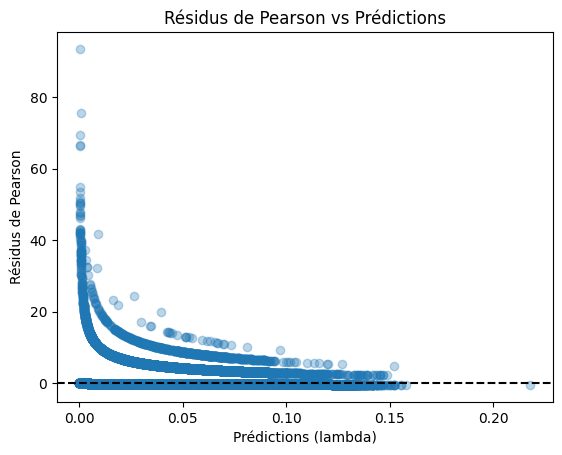

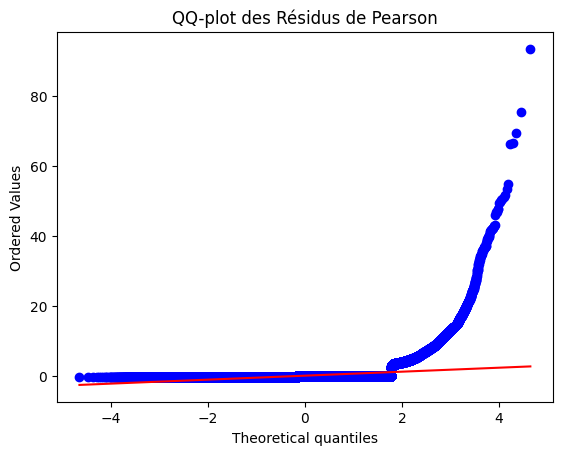

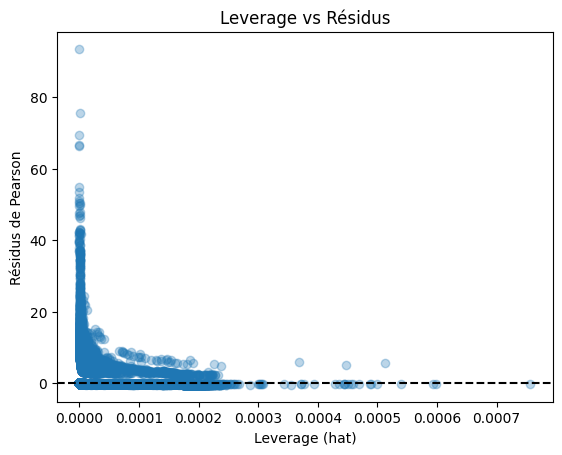

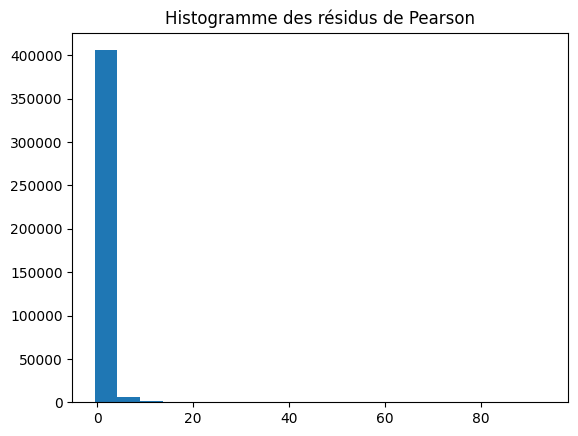

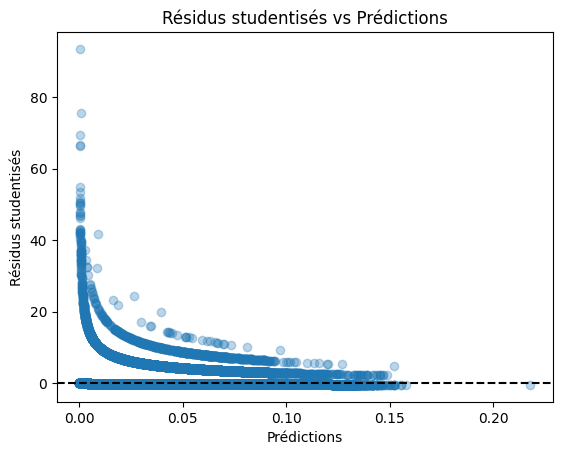

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from alibi.explainers import AnchorTabular
import pprint

# -----------------------------------
# 1. Chargement du dataset FreMTPL
# -----------------------------------
df = pd.read_csv(r"C:\Users\erwan\OneDrive\Bureau\DATA SCIENCE\DS2025-2026\.vscode\freMTPLfreq.csv")

# Variables explicatives
features = ["CarAge", "DriverAge", "Density"]   

# Exposure sort des features
X = df[features]
y = df["ClaimNb"]
exposure = df["Exposure"]

# -----------------------------------
# 2. Standardisation (optionnelle)
# -----------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------------
# 3. Modèle GLM Poisson AVEC OFFSET
# -----------------------------------
X_glm = sm.add_constant(X_scaled)
offset = np.log(exposure)

result = sm.GLM(
    y,
    X_glm,
    family=sm.families.Poisson(),
    offset=offset
).fit()

print(result.summary())

# ----------------------------------- 
# 3bis. Prédictions GLM avec offset 
# ----------------------------------- 
# Standardisation identique à l'entraînement 
X_scaled_pred = scaler.transform(X) 

# Ajout de la constante 
X_glm_pred = sm.add_constant(X_scaled_pred) 

# Prédiction avec offset 
df["PredictedFreq"] = result.predict(X_glm_pred, offset=offset) 

print("\nExemple de prédictions :") 
print(df[["ClaimNb", "PredictedFreq"]].head())

# -----------------------------------
# TEST AUTOMATIQUE DES SEUILS
# -----------------------------------

glm_scores = df["PredictedFreq"]

print("\n=== TEST DES SEUILS ===")
candidats = [0.50, 0.60, 0.70, 0.80, 0.90]

seuils = {}
for q in candidats:
    thr = np.quantile(glm_scores, q)
    proportion = np.mean(glm_scores > thr)
    seuils[q] = (thr, proportion)
    print(f"Quantile {q:.2f} → seuil={thr:.5f} → proportion classe 1={proportion:.3f}")

# -----------------------------------
# # # TEST AUTOMATIQUE DES SOUS-ENSEMBLES
# -----------------------------------

sous_ensembles = {
    "Exposure >= 0.5": df["Exposure"] >= 0.5,
    "Exposure >= 0.9": df["Exposure"] >= 0.9,
    "DriverAge >= 30": df["DriverAge"] >= 30,
    "DriverAge >= 40": df["DriverAge"] >= 40,
    "DriverAge >= 50": df["DriverAge"] >= 50,
    "DriverAge >= 60": df["DriverAge"] >= 60,
    "DriverAge <= 30": df["DriverAge"] <= 30,
    "DriverAge <= 40": df["DriverAge"] <= 40,
    "DriverAge <= 50": df["DriverAge"] <= 50,
    "DriverAge <= 60": df["DriverAge"] <= 60,
    "CarAge <= 10": df["CarAge"] <= 10,
    "CarAge <= 5": df["CarAge"] <= 5,
    "CarAge >= 10": df["CarAge"] >= 10,
    "CarAge >= 5": df["CarAge"] >= 5,
    "Density >= median": df["Density"] >= df["Density"].median()}

print("\n=== TEST DES SOUS-ENSEMBLES ===")

for nom, mask in sous_ensembles.items():
    X_sub = X[mask]
    y_sub = df["PredictedFreq"][mask]
    print(f"\n--- {nom} ---")
    print(f"Taille sous-ensemble : {len(X_sub)}")

    for q in [0.50, 0.60, 0.70, 0.80]:
        thr = np.quantile(y_sub, q)
        proportion = np.mean(y_sub > thr)
        print(f"  Quantile {q:.2f} → seuil={thr:.5f} → proportion classe 1={proportion:.3f}")

# -----------------------------------
# SELECTION AUTOMATIQUE DU MEILLEUR COUPLE
# -----------------------------------

meilleurs = []

for nom, mask in sous_ensembles.items():
    y_sub = df["PredictedFreq"][mask]

    for q in [0.50, 0.60, 0.70, 0.80]:
        thr = np.quantile(y_sub, q)
        proportion = np.mean(y_sub > thr)

        # Critère : proportion entre 20% et 40%
        if 0.20 <= proportion <= 0.40:
            meilleurs.append((nom, q, thr, proportion))

print("\n=== MEILLEURS COUPLES (sous-ensemble, seuil) ===")
for m in meilleurs:
    print(f"Sous-ensemble={m[0]} | quantile={m[1]} | seuil={m[2]:.5f} | proportion={m[3]:.3f}")

# -----------------------------------
# Sélection du meilleur sous-ensemble pour Anchors
# -----------------------------------

# Sous-ensemble choisi : DriverAge <= 50
mask = df["DriverAge"] <= 50
X_anchor = X[mask]
glm_anchor = df["PredictedFreq"][mask]

print("Taille sous-ensemble Anchors :", len(X_anchor))

# Seuil choisi : quantile 0.60 (40% classe 1)
quantile = 0.60
threshold_with_offset = np.quantile(glm_anchor, quantile)
print("Seuil AVEC offset :", threshold_with_offset)

# -----------------------------------
# 4. Calcul du seuil SANS offset (indispensable pour Anchors)
# -----------------------------------
X_scaled_no_offset = scaler.transform(X_anchor)
X_glm_no_offset = sm.add_constant(X_scaled_no_offset)
pred_no_offset = result.predict(X_glm_no_offset, offset=0)

threshold_no_offset = np.quantile(pred_no_offset, quantile)
print("Seuil SANS offset (utilisé par Anchors) :", threshold_no_offset)

# Vérification distribution classe 1
print("Distribution classe 1 :", 
      np.unique((pred_no_offset > threshold_no_offset).astype(int), return_counts=True))


def predict_fn(X_input):
    X_input = np.array(X_input, dtype=float).reshape(-1, len(features))

    # Standardisation
    X_scaled_local = scaler.transform(X_input)

    # Ajout explicite de la constante
    X_glm_local = sm.add_constant(X_scaled_local, has_constant='add')

    # Prédiction SANS offset (comme Anchors)
    preds = result.predict(X_glm_local, offset=0)

    # Classification binaire
    return (preds > threshold_no_offset).astype(int)

# -----------------------------------
# 5. Explicabilité avec Anchors
# -----------------------------------
explainer = AnchorTabular(
    predictor=predict_fn,
    feature_names=features)

explainer.fit(X_anchor.values)

# Observation à expliquer
i = 100
instance = X_anchor.iloc[i].values.reshape(1, -1)

# Explication
exp = explainer.explain(instance)

# Résultats
print("=== ANCHOR EXPLANATION ===")
print("Anchor:", exp.anchor)
print("Precision:", exp.precision)
print("Coverage:", exp.coverage)

print("\nExamples where anchor applies:")
pprint.pprint(exp.raw['examples'])

###############################################################
# 6. Affichage du résumé et prédiction
###############################################################
print(result.summary())

# Fréquence prédite
df["PredictedFreq"] = result.predict(X_glm_pred, offset=offset)

print("\nExemple de prédictions :")
print(df[["ClaimNb", "PredictedFreq"]].head())

# Résumé succinct
print(result.summary())

# AIC / BIC / Deviance / df_resid
print("AIC:", result.aic)
print("BIC:", result.bic)

#################l########Le déviance est plus petite
print("Deviance:", result.deviance)
print("df_resid:", result.df_resid)

# Effets multiplicatifs (exp(coef))
print("Exp(coeff):")
print(np.exp(result.params))

############################### Dispersion proche de 1
pearson_chi2 = sum(result.resid_pearson**2)
dispersion = pearson_chi2 / result.df_resid
print("Dispersion:", dispersion)

################### Parmètres interprétation
params = result.params
exp_params = np.exp(params)

print(exp_params) 

### le nombre de sinistre 
pred_freq = result.predict(X_glm_pred, offset=offset)

print("Fréquences prédites :")
print(pred_freq.head())
pred_claims = pred_freq * df["Exposure"]

######les graphiques : qqplot des résidus …
 
resid_pearson = result.resid_pearson
print(resid_pearson.head())

resid_deviance = result.resid_deviance
print(resid_deviance.head())

resid_std = resid_pearson / np.sqrt(1 - result.get_influence().hat_matrix_diag)
print(resid_std.head())

hat = result.get_influence().hat_matrix_diag
print(hat[:10])

import matplotlib.pyplot as plt

pred = result.predict(X_glm_pred, offset=offset)
resid_pearson = result.resid_pearson

plt.scatter(pred, resid_pearson, alpha=0.3)
plt.xlabel("Prédictions (lambda)")
plt.ylabel("Résidus de Pearson")
plt.title("Résidus de Pearson vs Prédictions")
plt.axhline(0, color="black", linestyle="--")
plt.show()

import scipy.stats as stats

stats.probplot(resid_pearson, dist="norm", plot=plt)
plt.title("QQ-plot des Résidus de Pearson")
plt.show()
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.scatter(hat, resid_pearson, alpha=0.3)
plt.xlabel("Leverage (hat)")
plt.ylabel("Résidus de Pearson")
plt.title("Leverage vs Résidus")
plt.axhline(0, color="black", linestyle="--")
plt.show()

plt.hist(resid_pearson, bins=20)
plt.title("Histogramme des résidus de Pearson")
plt.show()

influence = result.get_influence()
resid_std = influence.resid_studentized

plt.scatter(pred, resid_std, alpha=0.3)
plt.xlabel("Prédictions")
plt.ylabel("Résidus studentisés")
plt.title("Résidus studentisés vs Prédictions")
plt.axhline(0, color="black", linestyle="--")
plt.show()

In [ ]:

# ## ## ################ ## ## ################ ## ## ###############
#  Approche 2:  logistique avec la création de la variable binaire 
# ## ## ################ ## ## ################ ## ## ###############

# Création de la target binaire
df["HasClaim"] = (df["ClaimNb"] > 0).astype(int)

# Sélection des features et suppression des NaN
df = df[["HasClaim", "DriverAge", "CarAge", "Density"]].dropna()

# Équilibrage du dataset

df_majority = df[df.HasClaim == 0]
df_minority = df[df.HasClaim == 1]
df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

# Dataset final équilibré
df_balanced = pd.concat([df_minority, df_majority_downsampled])
X = df_balanced[["DriverAge", "CarAge", "Density"]]
y = df_balanced["HasClaim"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entraînement du Logit
X_train_const = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()
print(result.summary())

# Fonction prédictive pour AnchorTabular
def predict_fn(X_input):
    X_input = pd.DataFrame(X_input, columns=X.columns)
    X_input = sm.add_constant(X_input, has_constant='add')
    probs = result.predict(X_input)
    return np.vstack([1 - probs, probs]).T  # shape = [n_samples, 2]

# Création de l’explainer
feature_names = X.columns.tolist()
explainer = AnchorTabular(predictor=predict_fn, feature_names=feature_names)

# Discrétisation adaptée pour les features continues
explainer.fit(X_train.values, disc_perc=(5, 10, 25, 55, 75 , 90, 95))
np.random.seed(42)

#  Explication d’une instance
# Choix d’une instance avec HasClaim = 1 
instance = X_test[y_test == 1].iloc[0].values

explanation = explainer.explain(instance, threshold=0.9)

print("Anchor :", " AND ".join(explanation.anchor))
print("Precision :", explanation.precision)
print("Coverage :", explanation.coverage)



Optimization terminated successfully.
         Current function value: 0.692914
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:               HasClaim   No. Observations:                24624
Model:                          Logit   Df Residuals:                    24620
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Jan 2026   Pseudo R-squ.:               0.0003368
Time:                        13:17:49   Log-Likelihood:                -17062.
converged:                       True   LL-Null:                       -17068.
Covariance Type:            nonrobust   LLR p-value:                  0.009325
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0481      0.047      1.029      0.303      -0.044       0.140
DriverAge     -0.0020      0.

In [204]:

 # ## ## ################ ## ## ################ ## ## ###############
# Affichage de plusieurs Anchors
# ## ## ################ ## ## ################ ## ## ###############

# Génération des anchors locales pour toutes les instances sinistrées
X_test_claims = X_test[y_test == 1].values
anchors_raw = []

for instance in X_test_claims:
    explanation = explainer.explain(
        instance,
        threshold=0.7,        # précision minimale locale
        coverage_samples=1000   # ajustable
    )
    anchors_raw.append({
        "rule": " AND ".join(explanation.anchor),
        "precision": explanation.precision,
        "coverage": explanation.coverage
    })

#  Agrégation des règles locales en règles globales
df_rules = pd.DataFrame(anchors_raw)

global_rules = (
    df_rules.groupby("rule")
    .agg(
        freq=("rule", "count"),
        precision_mean=("precision","mean"),
        coverage_mean=("coverage","mean")
    )
    .reset_index()
)

#  Filtrage sur précision, coverage et fusion multi-variables
precision_min = 0.7
coverage_min = 0.2
min_vars = 2  # nombre minimum de variables dans la règle

# Sélection des règles fiables, globales et multi-variable
final_rules = global_rules[
    (global_rules["precision_mean"] >= precision_min) &
    (global_rules["coverage_mean"] >= coverage_min) &
    (global_rules["rule"].apply(lambda x: len(x.split(" AND ")) >= min_vars))
].sort_values(
    by=["precision_mean", "coverage_mean"],
    ascending=False
).head(3)  # <- top 3 règles multi-variable

# Affichage des 3 règles finales
print(f"\nTop 3 règles multi-variables retenues : {len(final_rules)}\n")

for i, row in final_rules.iterrows():
    print(
        f"{i+1}) {row['rule']}\n"
        f"   Precision moyenne = {row['precision_mean']:.3f}\n"
        f"   Coverage moyen    = {row['coverage_mean']:.3f}\n"
     
    )


                           Logit Regression Results                           
Dep. Variable:               HasClaim   No. Observations:                24624
Model:                          Logit   Df Residuals:                    24620
Method:                           MLE   Df Model:                            3
Date:                Tue, 06 Jan 2026   Pseudo R-squ.:               0.0003368
Time:                        11:40:43   Log-Likelihood:                -17062.
converged:                       True   LL-Null:                       -17068.
Covariance Type:            nonrobust   LLR p-value:                  0.009325
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0481      0.047      1.029      0.303      -0.044       0.140
DriverAge     -0.0020      0.001     -2.314      0.021      -0.004      -0.000
CarAge         0.0046      0.002      1.974      0.0